# Train Kernel Parameters

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/train-kernel-parameters/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/).*

In this example we show a few ways to perform regression on a kernel from KernelFunctions.jl.

We load KernelFunctions and some other packages

In [1]:
using KernelFunctions
using LinearAlgebra
using Distributions
using Plots;
using BenchmarkTools
using Flux
using Flux: Optimise
using Zygote
using Random: seed!
seed!(42);

## Data Generation
We generated data in 1 dimension

In [2]:
xmin = -3;
xmax = 3; # Bounds of the data
N = 50 # Number of samples
x_train = rand(Uniform(xmin, xmax), N) # We sample 100 random samples
σ = 0.1
y_train = sinc.(x_train) + randn(N) * σ # We create a function and add some noise
x_test = range(xmin - 0.1, xmax + 0.1; length=300)
nothing #hide

Plot the data

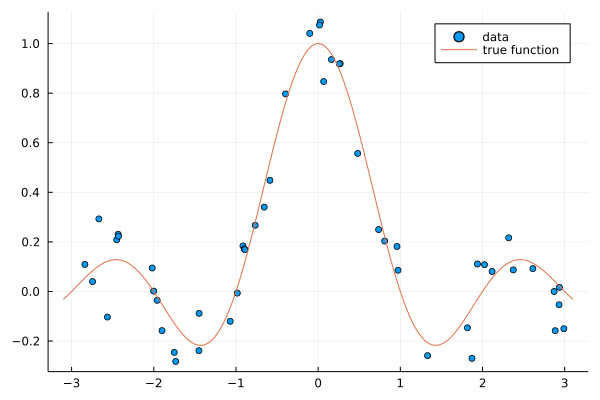

In [3]:
scatter(x_train, y_train; lab="data")
plot!(x_test, sinc; lab="true function")

## Base Approach
The first option is to rebuild the parametrized kernel from a vector of parameters
in each evaluation of the cost fuction. This is similar to the approach taken in
[Stheno.jl](https://github.com/JuliaGaussianProcesses/Stheno.jl).

To train the kernel parameters via ForwardDiff.jl
we need to create a function creating a kernel from an array.
A simple way to ensure that the kernel parameters are positive
is to optimize over the logarithm of the parameters.

In [4]:
function kernelcall(θ)
    return (exp(θ[1]) * SqExponentialKernel() + exp(θ[2]) * Matern32Kernel()) ∘
           ScaleTransform(exp(θ[3]))
end
nothing #hide

From theory we know the prediction for a test set x given
the kernel parameters and normalization constant

In [5]:
function f(x, x_train, y_train, θ)
    k = kernelcall(θ[1:3])
    return kernelmatrix(k, x, x_train) *
           ((kernelmatrix(k, x_train) + exp(θ[4]) * I) \ y_train)
end
nothing #hide

We look how the prediction looks like
with starting parameters [1.0, 1.0, 1.0, 1.0] we get :

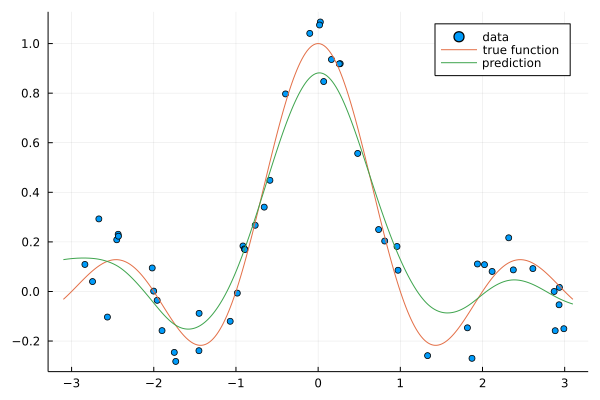

In [6]:
ŷ = f(x_test, x_train, y_train, log.(ones(4)))
scatter(x_train, y_train; lab="data")
plot!(x_test, sinc; lab="true function")
plot!(x_test, ŷ; lab="prediction")

We define the loss based on the L2 norm both
for the loss and the regularization

In [7]:
function loss(θ)
    ŷ = f(x_train, x_train, y_train, θ)
    return sum(abs2, y_train - ŷ) + exp(θ[4]) * norm(ŷ)
end
nothing #hide

### Training
Setting an initial value and initializing the optimizer:

In [8]:
θ = log.([1.1, 0.1, 0.01, 0.001]) # Initial vector
opt = Optimise.ADAGrad(0.5)
nothing #hide

The loss with our starting point:

In [9]:
loss(θ)

6.826611997832667

Computational cost for one step

In [10]:
@benchmark let θt = θ[:], optt = Optimise.ADAGrad(0.5)
    grads = only((Zygote.gradient(loss, θt)))
    Optimise.update!(optt, θt, grads)
end

BenchmarkTools.Trial: 2813 samples with 1 evaluation.
 Range (min … max):  1.295 ms … 13.135 ms  ┊ GC (min … max): 0.00% … 86.30%
 Time  (median):     1.634 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.769 ms ±  1.069 ms  ┊ GC (mean ± σ):  7.79% ± 10.66%

    █                                                         
  ▃██▅▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂ ▂
  1.3 ms         Histogram: frequency by time        9.63 ms <

 Memory estimate: 1.96 MiB, allocs estimate: 1971.

Optimizing

In [11]:
anim = Animation()
for i in 1:25
    grads = only((Zygote.gradient(loss, θ)))
    Optimise.update!(opt, θ, grads)
    scatter(
        x_train, y_train; lab="data", title="i = $(i), Loss = $(round(loss(θ), digits = 4))"
    )
    plot!(x_test, sinc; lab="true function")
    plot!(x_test, f(x_test, x_train, y_train, θ); lab="Prediction", lw=3.0)
    frame(anim)
end
gif(anim, "train-kernel-param.gif"; show_msg=false, fps=15);
nothing; #hide

![](train-kernel-param.gif)

Final loss

In [12]:
loss(θ)

0.3115230878633516

## Using ParameterHandling.jl
Alternatively, we can use the [ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl) package
to handle the requirement that all kernel parameters should be positive.

In [13]:
using ParameterHandling

raw_initial_θ = (
    k1=positive(1.1), k2=positive(0.1), k3=positive(0.01), noise_var=positive(0.001)
)

flat_θ, unflatten = ParameterHandling.value_flatten(raw_initial_θ)
nothing #hide

function kernelcall(θ)
    return (θ.k1 * SqExponentialKernel() + θ.k2 * Matern32Kernel()) ∘ ScaleTransform(θ.k3)
end
nothing #hide

function f(x, x_train, y_train, θ)
    k = kernelcall(θ)
    return kernelmatrix(k, x, x_train) *
           ((kernelmatrix(k, x_train) + θ.noise_var * I) \ y_train)
end
nothing #hide

function loss(θ)
    ŷ = f(x_train, x_train, y_train, θ)
    return sum(abs2, y_train - ŷ) + θ.noise_var * norm(ŷ)
end
nothing #hide

initial_θ = ParameterHandling.value(raw_initial_θ)
nothing #hide

The loss with our starting point :

In [14]:
(loss ∘ unflatten)(flat_θ)

6.826611997832667

## Training the model

### Cost per step

In [15]:
@benchmark let θt = flat_θ[:], optt = Optimise.ADAGrad(0.5)
    grads = (Zygote.gradient(loss ∘ unflatten, θt))[1]
    Optimise.update!(optt, θt, grads)
end

BenchmarkTools.Trial: 2541 samples with 1 evaluation.
 Range (min … max):  1.456 ms … 11.016 ms  ┊ GC (min … max): 0.00% … 78.53%
 Time  (median):     1.826 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.960 ms ±  1.097 ms  ┊ GC (mean ± σ):  7.18% ± 10.46%

   ▁█▁                                                        
  ▄███▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂ ▂
  1.46 ms        Histogram: frequency by time        10.2 ms <

 Memory estimate: 1.99 MiB, allocs estimate: 2731.

### Complete optimization

In [16]:
opt = Optimise.ADAGrad(0.5)
for i in 1:25
    grads = (Zygote.gradient(loss ∘ unflatten, flat_θ))[1]
    Optimise.update!(opt, flat_θ, grads)
end
nothing #hide

Final loss

In [17]:
(loss ∘ unflatten)(flat_θ)

0.3115268205943201

## Flux.destructure
If don't want to write an explicit function to construct the kernel, we can alternatively use the `Flux.destructure` function.
Again, we need to ensure that the parameters are positive. Note that the `exp` function is now part of the loss function, instead of part of the kernel construction.

In [18]:
θ = [1.1, 0.1, 0.01, 0.001]

kernel = (θ[1] * SqExponentialKernel() + θ[2] * Matern32Kernel()) ∘ ScaleTransform(θ[3])

p, kernelc = Flux.destructure(kernel);

This returns the `trainable` parameters of the kernel and a function to reconstruct the kernel.

In [19]:
kernelc(p)

Sum of 2 kernels:
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
			- σ² = 1.1
	Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
			- σ² = 0.1
	- Scale Transform (s = 0.01)

From theory we know the prediction for a test set x given
the kernel parameters and normalization constant

In [20]:
function f(x, x_train, y_train, θ)
    k = kernelc(θ[1:3])
    return kernelmatrix(k, x, x_train) * ((kernelmatrix(k, x_train) + (θ[4]) * I) \ y_train)
end
nothing #hide

We define the loss based on the L2 norm both
for the loss and the regularization

In [21]:
function loss(θ)
    ŷ = f(x_train, x_train, y_train, exp.(θ))
    return sum(abs2, y_train - ŷ) + exp(θ[4]) * norm(ŷ)
end
nothing #hide

## Training the model

The loss with our starting point :

In [22]:
θ = log.([1.1, 0.1, 0.01, 0.001]) # Initial vector
loss(θ)

6.826611997832667

Initialize optimizer

In [23]:
opt = Optimise.ADAGrad(0.5)
nothing #hide

Cost for one step

In [24]:
@benchmark let θt = θ[:], optt = Optimise.ADAGrad(0.5)
    grads = only((Zygote.gradient(loss, θt)))
    Optimise.update!(optt, θt, grads)
end

BenchmarkTools.Trial: 2737 samples with 1 evaluation.
 Range (min … max):  1.300 ms … 10.407 ms  ┊ GC (min … max): 0.00% … 82.01%
 Time  (median):     1.673 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.818 ms ±  1.082 ms  ┊ GC (mean ± σ):  7.25% ± 10.26%

  ▁▆█▅                                                        
  ████▆▅▅▃▃▁▁▄▁▁▁▁▁▁▃▁▁▃▃▃▄▃▅▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▅▇ █
  1.3 ms       Histogram: log(frequency) by time     9.98 ms <

 Memory estimate: 1.96 MiB, allocs estimate: 2054.

The optimization

In [25]:
for i in 1:25
    grads = only((Zygote.gradient(loss, θ)))
    Optimise.update!(opt, θ, grads)
end
nothing #hide

Final loss

In [26]:
loss(θ)

0.3115230878633516

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*